In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from matplotlib import gridspec
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Pre-Processing and EDA 

1) Checking for null values

In [3]:
df.isnull().values.any()

False

2) Checking Target values Distributions


Text(0.5, 1.0, 'Target values Distribution (Fraud = 1 | Not Fraud = 0')

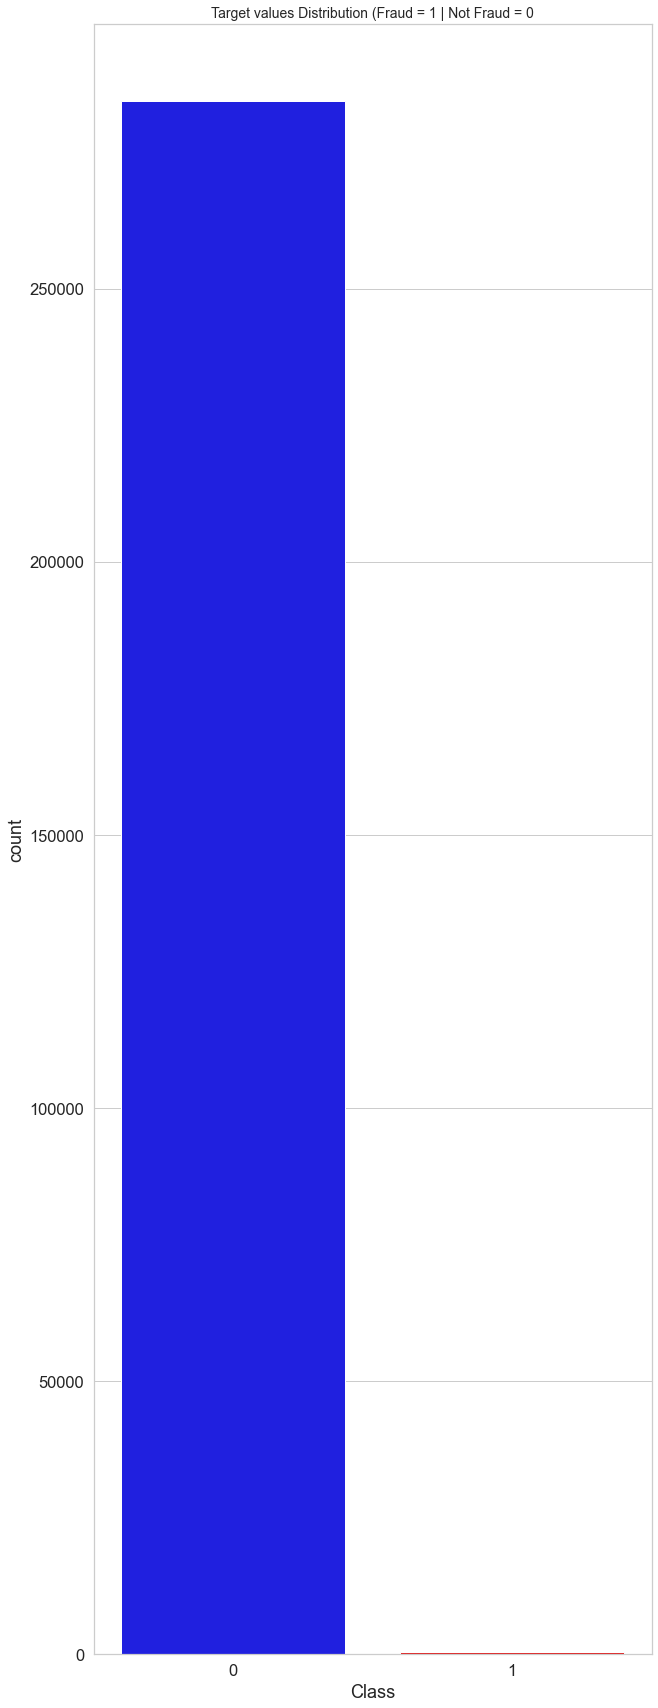

In [4]:
colors = ['Blue', 'Red']
fig, ax = plt.subplots(figsize=(10, 30))
sns.countplot('Class',ax=ax, data=df, palette=colors)
plt.title('Target values Distribution (Fraud = 1 | Not Fraud = 0', fontsize=14)


3) Getting More details about the target values

In [5]:
print('No Frauds', df['Class'].value_counts()[0])
print('Frauds', df['Class'].value_counts()[1])

No Frauds 284315
Frauds 492


4) Checking the features

In [6]:
Frauds = df[df.Class == 1]
Not_frauds = df[df.Class == 0]

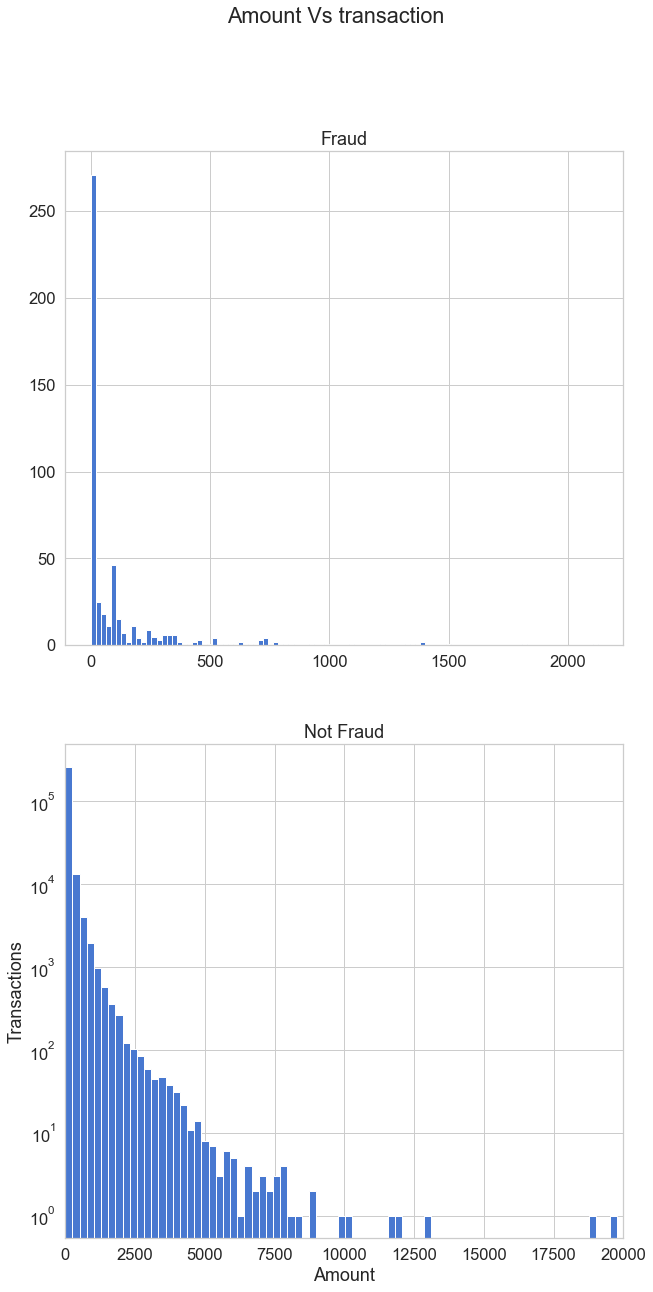

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 20))
f.suptitle('Amount Vs transaction')


ax1.hist(Frauds.Amount, bins = 100)
ax1.set_title('Fraud')

ax2.hist(Not_frauds.Amount, bins = 100)
ax2.set_title('Not Fraud')

plt.xlabel('Amount')
plt.ylabel('Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

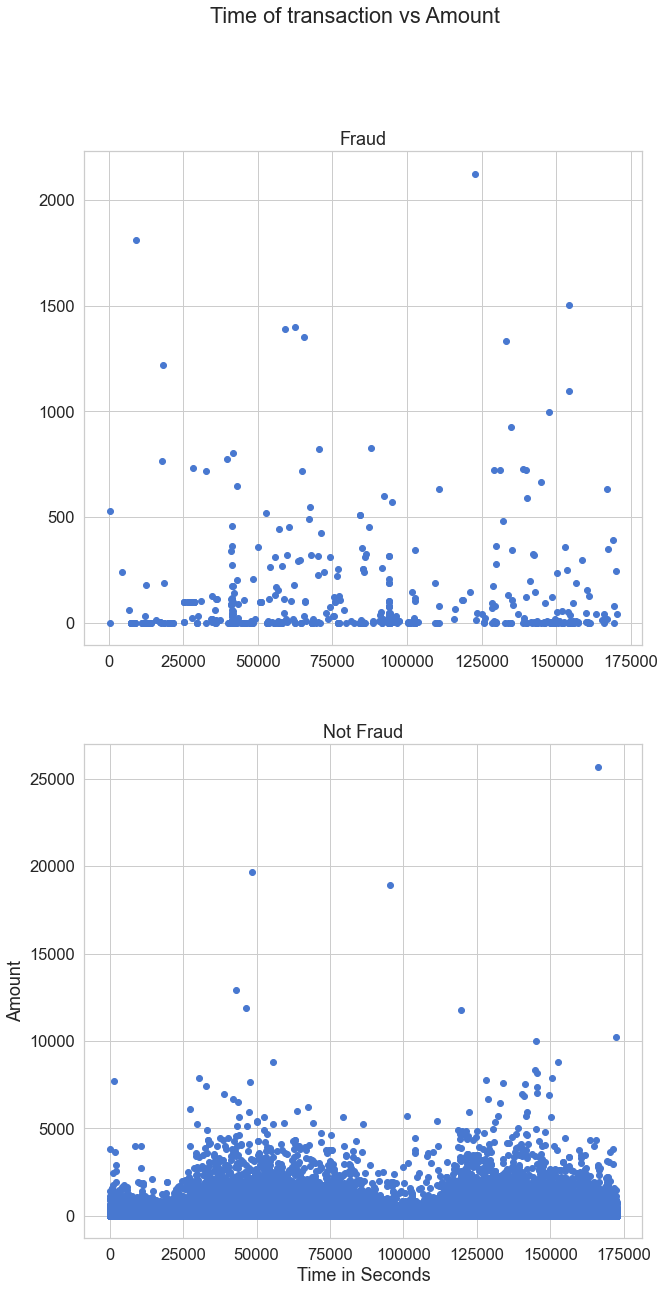

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 20))
f.suptitle('Time of transaction vs Amount')

ax1.scatter(Frauds.Time, Frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(Not_frauds.Time, Not_frauds.Amount)
ax2.set_title('Not Fraud')

plt.xlabel('Time in Seconds')
plt.ylabel('Amount')
plt.show()

Anonymous feature analysis

In [9]:
AFeatures = df.iloc[:, 1:29].columns

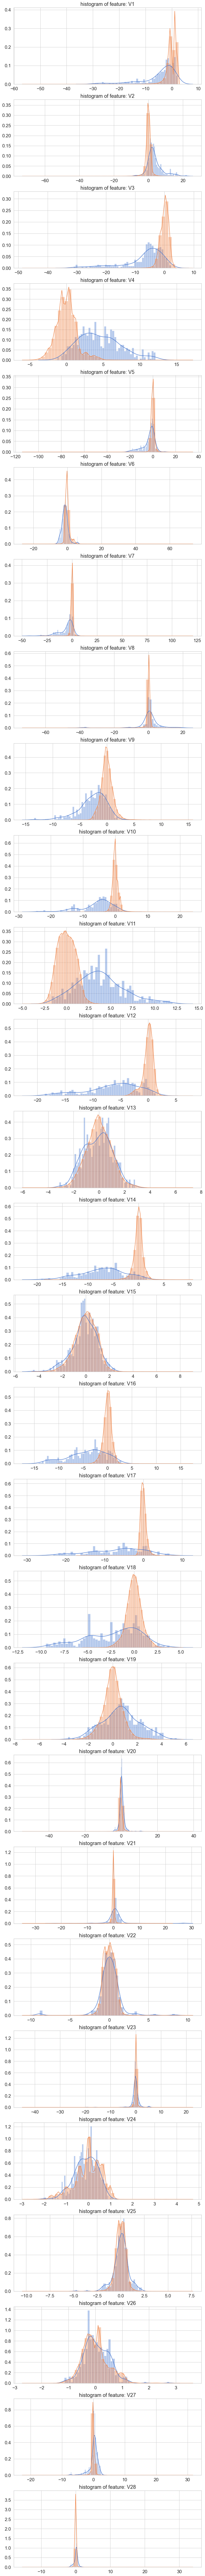

In [10]:
from matplotlib import gridspec
plt.figure(figsize=(12,28*6))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[AFeatures]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

Selecting the Features

In [11]:
dataset = df.drop(['V13','V15', 'V20', 'V22', 'V24', 'V25','V26','V27', 'Time'], axis =1)

In [12]:
dataset.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V14,V16,V17,V18,V19,V21,V23,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,-0.110474,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,0.101288,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,0.909412,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,-0.190321,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,-0.137458,0.215153,69.99,0


Scaling the amount column

In [13]:
dataset['Amount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [14]:
non_fraud = dataset[dataset['Class'] == 0]
fraud = dataset[dataset['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [15]:
from tensorflow.keras.optimizers import Adam
autoencoder = Sequential()
autoencoder.add(Dense(100,  activation='relu', input_shape=(X.shape[1],)))
autoencoder.add(Dense(50,  activation='relu'))
autoencoder.add(Dense(10,    activation='linear', name="Compressed"))
autoencoder.add(Dense(50,  activation='relu'))
autoencoder.add(Dense(100,  activation='relu'))
autoencoder.add(Dense(X.shape[1],  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adadelta')

In [16]:
x = dataset.drop(["Class"], axis=1)
y = dataset["Class"].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [17]:
autoencoder.fit(x_norm[:2000], x_norm[:2000], batch_size=256, 
                                epochs=10, verbose=1, validation_split = 0.20)

Epoch 1/10
7/7 [==============================] - 0s 20ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 4/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0596
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0595
Epoch 10/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0595


In [18]:
encoder = Model(autoencoder.input, autoencoder.get_layer('Compressed').output)

In [19]:
encoded_nf = encoder.predict(x_norm[:5000])
encoded_f = encoder.predict(x_fraud)

In [20]:
encoded_X = np.append(encoded_nf, encoded_f, axis = 0)
nf_Y = np.zeros(encoded_nf.shape[0])
f_Y = np.ones(encoded_f.shape[0])
encoded_Y = np.append(nf_Y, f_Y)

In [21]:
XTrain, XVal, YTrain, YVal = train_test_split(encoded_X, encoded_Y, test_size=0.25)

In [32]:
clf = LogisticRegression(solver="liblinear", penalty='l1', max_iter=500).fit(XTrain, YTrain)
YPred = clf.predict(XVal)

print ("")
print ("Classification Report: ")
print (classification_report(YVal, YPred))

print ("")
print ("Accuracy Score: ", accuracy_score(YVal, YPred))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1248
         1.0       0.95      0.79      0.86       125

    accuracy                           0.98      1373
   macro avg       0.97      0.89      0.93      1373
weighted avg       0.98      0.98      0.98      1373


Accuracy Score:  0.9774217042971595


In [33]:
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold

In [34]:
model_xgb = xgb.XGBClassifier(n_estimators=380, max_depth=2, learning_rate=0.2)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_xgb, XTrain, YTrain, scoring='accuracy', cv=cv, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.983 (0.007)


In [35]:
model_xgb.fit(XTrain, YTrain)
xgb_preds = model_xgb.predict(XVal)

In [36]:
model_xgb.score(XVal, YVal)

0.9847050254916242

In [37]:
print ("")
print ("Classification Report: ")
print (classification_report(YVal, xgb_preds))

print ("")
print ("Accuracy Score: ", accuracy_score(YVal, xgb_preds))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1248
         1.0       0.93      0.90      0.91       125

    accuracy                           0.98      1373
   macro avg       0.96      0.95      0.95      1373
weighted avg       0.98      0.98      0.98      1373


Accuracy Score:  0.9847050254916242


In [38]:
from sklearn.metrics import confusion_matrix 

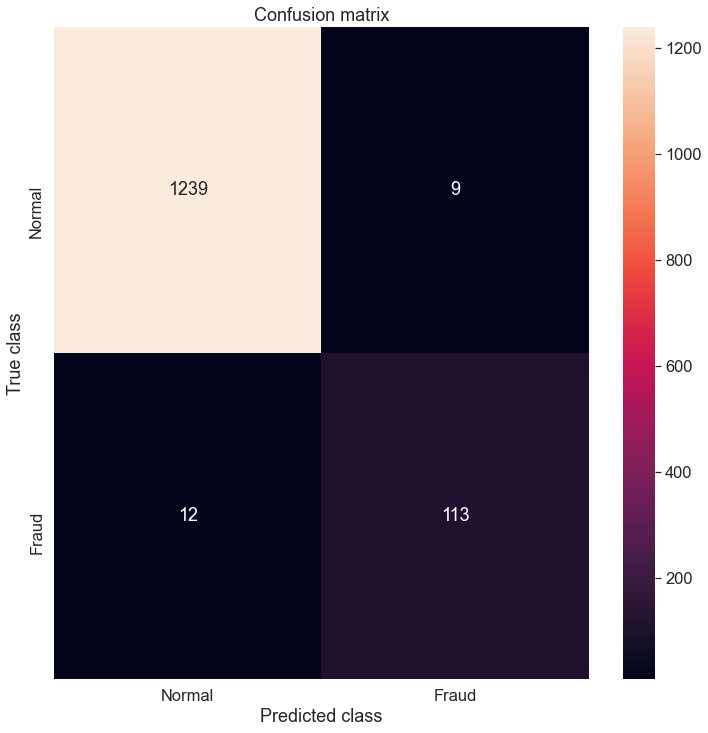

In [29]:
LABELS = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(YVal, xgb_preds) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()